## Step-by-step implementation of region-CNN from Scratch Using Tensorflow Keras fit_generator function
Here, the airplane dataset is used to detect the airplanes from the remote sensing images. The dataset is available in the following link http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html

Patches are extracted using Selective Search algorithm based on intersection of Union (IoU) value and saved in a directory. Later, the pathces are splitted into train validation and train dataset. The fine tuned VGG16 model has been trained using keras fit_generator function

### Import libraries

In [1]:
import os
import cv2
import keras
from keras.layers import Dense
from keras import Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
from tqdm import tqdm
import tensorflow as tf

Using TensorFlow backend.


### Path of image and annotation directory

In [2]:
# This folder contians all the airplanes images
image_path = os.path.join(os.getcwd(), "airplanes/images")
# This folder contians all the annotations of the respective images
annotation_path = os.path.join(os.getcwd(), "airplanes/annotations")

### Display sample images with annotations (ground truth boundary boxes)

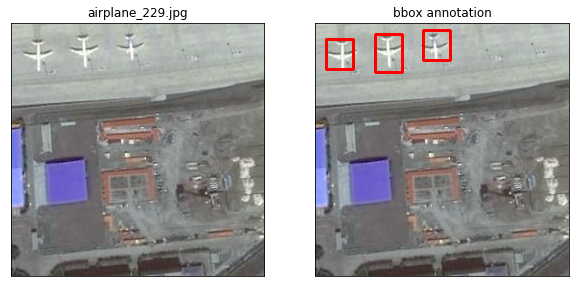

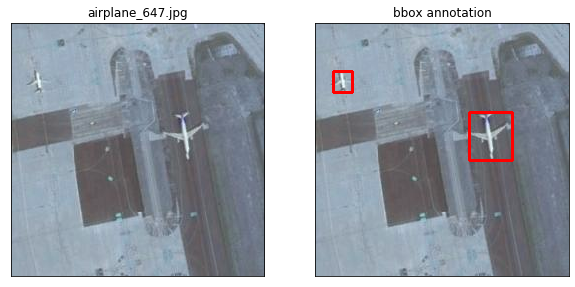

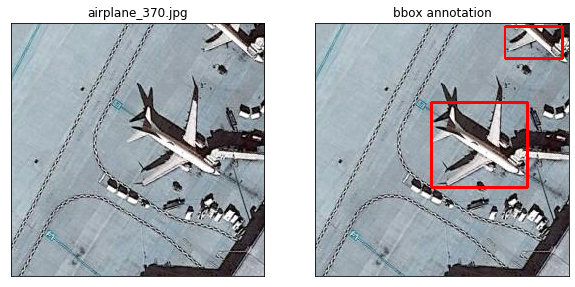

In [3]:
for i in range(3):
    fig = plt.figure(figsize=(10,10))
    idx = np.random.choice(os.listdir(annotation_path))

    img_file = idx.split(".")[0] + ".jpg"
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, idx))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(img_file), plt.xticks([]), plt.yticks([])
    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2) # (x1,y1) -> start point and (x2,y2) -> end pint of the bbox
    fig.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.title("bbox annotation"), plt.xticks([]), plt.yticks([])

### Region detection using selective searches and display the results

In [4]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Text(0.5, 1.0, '357 regions detected')

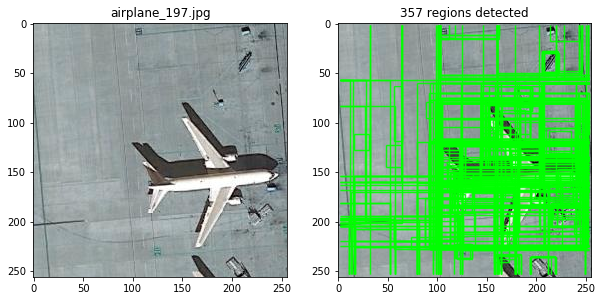

In [5]:
img_file = np.random.choice(os.listdir(image_path))
img = cv2.imread(os.path.join(image_path, img_file))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
regions = ss.process()

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title(img_file)

for i, region in enumerate(regions):
    x, y, w, h = region
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
fig.add_subplot(1,2,2)
plt.imshow(img)
title = str(len(regions)) + " regions detected"
plt.title(title)

### Patch extraction uisng selective search and save to folder
Patch extraction is needed only for the first time. Do not run these (cell 6 to 9) if you run this program second time

#### Define the function to calculate the Intersection of Union (IoU)

In [6]:
def get_iou(bbox1, bbox2):   
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bbox1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bbox2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

#### Manage patch directories

In [7]:
patch_dir = os.path.join(os.getcwd(), "patches")
airplane_patches_dir = os.path.join(patch_dir, "airplanes")
background_patches_dir = os.path.join(patch_dir, "backgorund")

if os.path.exists(patch_dir):
    shutil.rmtree(patch_dir)
os.mkdir(patch_dir)
os.mkdir(airplane_patches_dir)
os.mkdir(background_patches_dir)

#### Extract patches and save to folder

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [9]:
for i,annotation_file in enumerate(tqdm(os.listdir(annotation_path))):
    img_file = annotation_file.split(".")[0] + '.jpg'
    #print(i, img_file)
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, annotation_file))
    gtbboxes = []

    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtbboxes.append({'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})

    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process() # return region as (x,y,width and height) form

    counter = 0
    falsecounter = 0

    temp_img = img.copy()
    for c, region in enumerate(regions):
        if c < 2000:
            for gtbbox in gtbboxes:
                x,y,w,h = region 
                iou = get_iou(gtbbox, {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h})
                if counter < 30:
                    if iou > 0.70:
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        file_name = annotation_file.split(".")[0] + "_" + str(counter) + '.jpg'
                        cv2.imwrite(os.path.join(airplane_patches_dir, file_name), resized_img)
                        counter += 1

                if falsecounter < 30:
                    if iou < 0.3 :
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        file_name = annotation_file.split(".")[0] + "_" + str(falsecounter) + '.jpg'
                        cv2.imwrite(os.path.join(background_patches_dir, file_name), resized_img)
                        falsecounter += 1

100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [07:05<00:00,  1.64it/s]


### Split the patches into train, validation and test folder

#### Degine the train, validation and test folder. Each folder contains two subfolder 1) airplane 2) background

In [10]:
root_dir = os.path.join(os.getcwd(), "images")

train_dir = os.path.join(root_dir, "train")
train_dir_a = os.path.join(train_dir, "airplane")
train_dir_b = os.path.join(train_dir, "background")

val_dir = os.path.join(root_dir, "val")
val_dir_a = os.path.join(val_dir, "airplane")
val_dir_b = os.path.join(val_dir, "background")

test_dir = os.path.join(root_dir, "test")


#### Create the folders, it will overwrite the folders

In [11]:
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)
os.mkdir(root_dir)

os.mkdir(train_dir)
os.mkdir(train_dir_a)
os.mkdir(train_dir_b)

os.mkdir(val_dir)
os.mkdir(val_dir_a)
os.mkdir(val_dir_b)

os.mkdir(test_dir)

#### Copy the files to respective folders (85% train, 14% validation and 1% for testing)

In [13]:
n_test = int(len(os.listdir(airplane_patches_dir))*0.01)

for path in [airplane_patches_dir, background_patches_dir]:
    n_train = int(len(os.listdir(path))*0.85)
    n_val = int(len(os.listdir(path))*0.14)
    
    train_sample = np.random.choice(os.listdir(path), n_train, replace=False)
    rest = list(set(os.listdir(path)) - set(train_sample))
    val_sample = np.random.choice(rest, n_val, replace=False)
    rest = list(set(rest) - set(val_sample))
    test_sample = np.random.choice(rest, n_test, replace=False)
    
    if path == airplane_patches_dir:
        print("Copying {} train airplane patches...".format(n_train))
        for file in tqdm(train_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, train_dir_a) 

        print("Copying {} validation airplane patches...".format(n_val))
        for file in tqdm(val_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, val_dir_a)
            
        print("Copying {} test airplane patches...".format(n_test))
        for file in tqdm(test_sample):
            src_file = os.path.join(airplane_patches_dir, file)
            shutil.copy(src_file, test_dir)
    
    if path == background_patches_dir:
        print("Copying {} train background patches...".format(n_train))
        for file in tqdm(train_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, train_dir_b) 

        print("Copying {} validation background patches...".format(n_val))
        for file in tqdm(val_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, val_dir_b)
            
        print("Copying {} test background patches...".format(n_test))
        for file in tqdm(test_sample):
            src_file = os.path.join(background_patches_dir, file)
            shutil.copy(src_file, test_dir)
        

Copying 7895 train airplane patches...


100%|████████████████████████████████████████████████████████████████████████████| 7895/7895 [00:07<00:00, 1066.61it/s]


Copying 1300 validation airplane patches...


100%|█████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 799.63it/s]


Copying 92 test airplane patches...


100%|█████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 931.35it/s]


Copying 17799 train background patches...


100%|███████████████████████████████████████████████████████████████████████████| 17799/17799 [00:22<00:00, 780.27it/s]


Copying 2931 validation background patches...


100%|█████████████████████████████████████████████████████████████████████████████| 2931/2931 [00:03<00:00, 893.34it/s]


Copying 92 test background patches...


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 1167.86it/s]


### Develop the model

#### Load the VGG16 model

In [14]:
vggmodel = VGG16(weights='imagenet', include_top=True)
#vggmodel.summary()

#### Fine tune the model

In [15]:
# Freeze the first 15 layers
for layers in (vggmodel.layers)[:15]:
    #print(layers)
    layers.trainable = False

# Remove the last layers and change to class 2 instead of 1000
X = vggmodel.layers[-2].output
predictions = Dense(2, activation='softmax')(X)
model = Model(input=vggmodel.input, output=predictions)
model.summary()

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Data augmentation using Keras ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True, 
                            rotation_range=90)
train_data = datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=10)
val_data = datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)

Found 25694 images belonging to 2 classes.
Found 4231 images belonging to 2 classes.


### Compile the model

In [17]:
lr = 0.0001
model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=Adam(lr=lr),
                   metrics=['accuracy'])

### Set model checkpoint

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("region_cnn.h5", monitor='val_loss',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

### Train the model

In [ ]:
total_train_images = 25694
total_val_images = 4231
batch_size = 10
epochs = 30
trained_model = model.fit_generator(generator=train_data,
                                          steps_per_epoch= total_train_images//batch_size,
                                          epochs=epochs,
                                          validation_data=val_data,
                                          validation_steps=total_val_images//batch_size,
                                          callbacks=[checkpoint, early])

### Dispaly the accuracy and loss graph

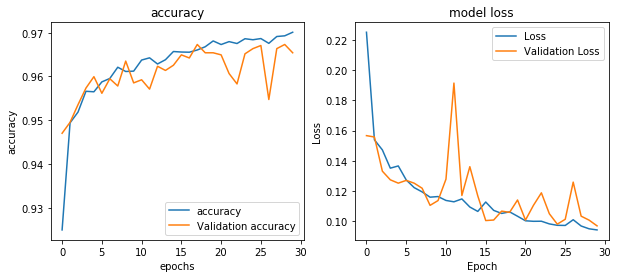

In [20]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(trained_model.history["acc"])
plt.plot(trained_model.history['val_acc'])
plt.title("accuracy"), plt.ylabel("accuracy"), plt.xlabel("epochs")
plt.legend(["accuracy","Validation accuracy"])

fig.add_subplot(1,2,2)
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title("model loss"), plt.ylabel("Loss"), plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
#plt.show()
#plt.savefig('chart loss.png')

### Prediction of some patches

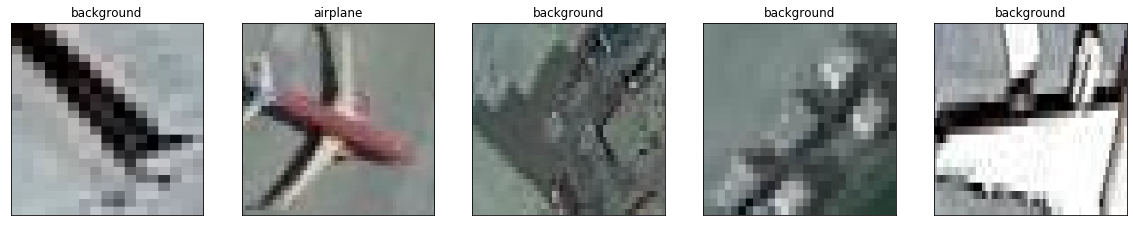

In [21]:
rows = 1
cols = 5
img_files = np.random.choice(os.listdir(test_dir), rows*cols)

fig = plt.figure(figsize=(20,20))
for i, file in enumerate(img_files):
    img = cv2.imread(os.path.join(test_dir,file))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    out= model.predict(img)
    if out[0][0] > out[0][1]:
        plt.title("airplane")
    else:
        plt.title("background")
    plt.xticks([]), plt.yticks([])

### Display the airplane detection results

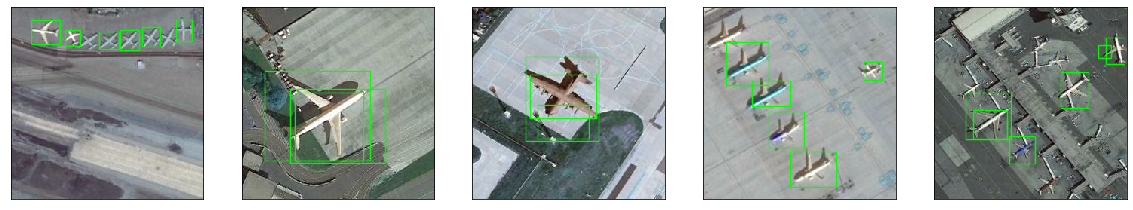

In [23]:
rows = 1
cols = 5
img_files = np.random.choice(os.listdir(image_path), rows*cols)

fig = plt.figure(figsize=(20, 20))

for i, file in enumerate(img_files):
    img = cv2.imread(os.path.join(image_path,file))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process()
    imout = img.copy()
    for e,region in enumerate(regions):
        if e < 2000:
            x,y,w,h = region
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img)
            if out[0][0] > 0.7:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(imout)
    plt.xticks([]), plt.yticks([])